In [16]:
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyter-gpu/lib/python3.10/site-packages")
from utils import *
from functions import *
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture 
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import validation_curve

os.environ['TF_ENABLE_ONEDNN_OPTS']='0'

from sklearn.metrics import adjusted_mutual_info_score

import os
import scipy.io

In [17]:
# Load dataset from file
folder_path = '/mnt/home/tudomlumleart/ceph/05_Sox9Dataset/'

# List all .mat files in the folder and load them
cnc_maps = scipy.io.loadmat(folder_path + 'cncMaps.mat')['cncMaps'][:80, :80, :]
esc_maps = scipy.io.loadmat(folder_path + 'escMaps.mat')['escMaps'][:80, :80, :]

# Load polys data and then perform linear interpolation
# List all .mat files in the folder and load them
cnc_polys = scipy.io.loadmat(folder_path + 'cncPols.mat')['cncPols'][:80, :, :]
esc_polys = scipy.io.loadmat(folder_path + 'escPols.mat')['escPols'][:80, :, :]


In [18]:
save_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/figures/20240730'

In [19]:
def interpolate_polymers(polys):
    num_probes, num_coords, num_cells = polys.shape
    new_polys = np.zeros((num_probes, num_coords, num_cells))
    for c in range(num_cells):
        curr_cells = polys[:, :, c]
        for x in range(num_coords):
            curr_coords = curr_cells[:, x]
            missing_indices = np.isnan(curr_coords)
            valid_indices = ~missing_indices
            interp_coords = np.interp(np.flatnonzero(missing_indices), np.flatnonzero(valid_indices), curr_coords[valid_indices])
            new_polys[missing_indices, x, c] = interp_coords
            new_polys[valid_indices, x, c] = curr_coords[valid_indices]
    return new_polys

In [20]:
esc_polys_interp = interpolate_polymers(esc_polys)
cnc_polys_interp = interpolate_polymers(cnc_polys)

esc_maps_interp = np.array([squareform(pdist(esc_polys_interp[:, :, i])) for i in range(esc_polys_interp.shape[2])])
cnc_maps_interp = np.array([squareform(pdist(cnc_polys_interp[:, :, i])) for i in range(cnc_polys_interp.shape[2])])
esc_maps_interp_flat = np.array([x.flatten() for x in esc_maps_interp])
cnc_maps_interp_flat = np.array([x.flatten() for x in cnc_maps_interp])
all_maps_interp_flat = np.concatenate((esc_maps_interp_flat, cnc_maps_interp_flat), axis=0)

In [13]:
bgmm = BayesianGaussianMixture(n_components=10, 
                               covariance_type='diag',
                               random_state=0,
                               weight_concentration_prior=100,
                               init_params='k-means++',
                               n_init=10,
                               tol=1e-6)
bgmm.fit(all_maps_interp_flat)

BayesianGaussianMixture(covariance_type='diag', init_params='k-means++',
                        n_components=10, n_init=10, random_state=0, tol=1e-06,
                        weight_concentration_prior=100)

(0.0, 1.0)

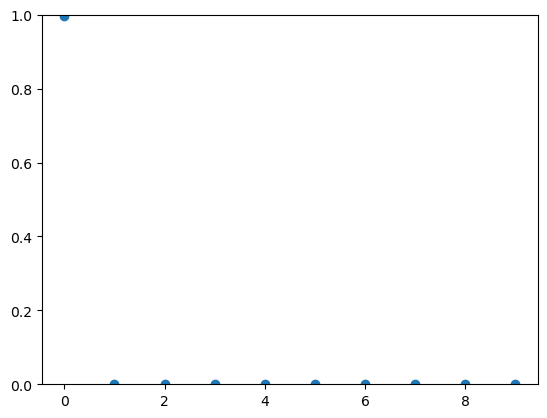

In [14]:
plt.plot(bgmm.weights_, 'o')
plt.ylim(0, 1)

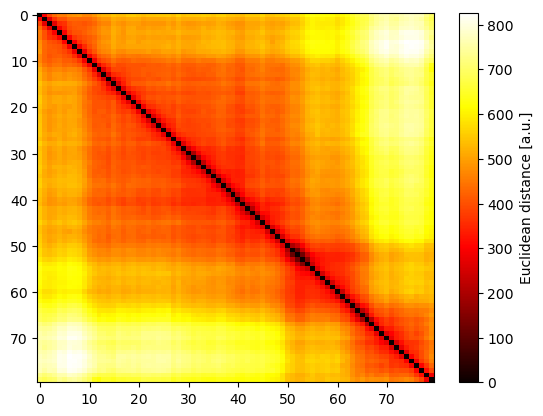

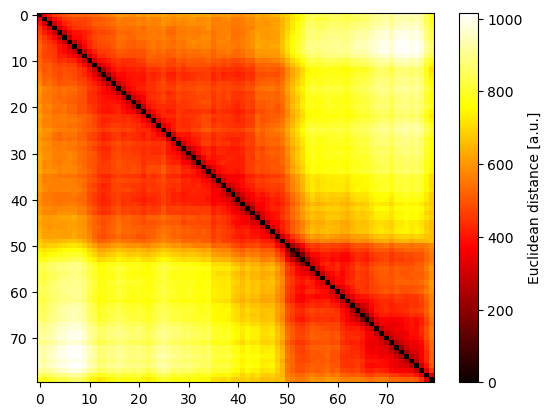

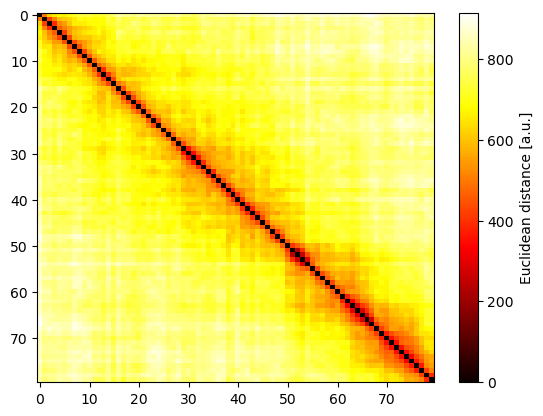

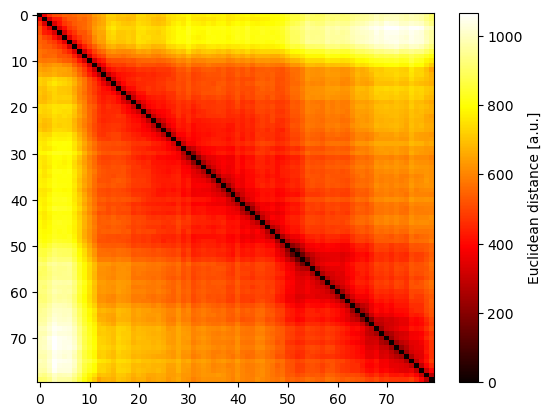

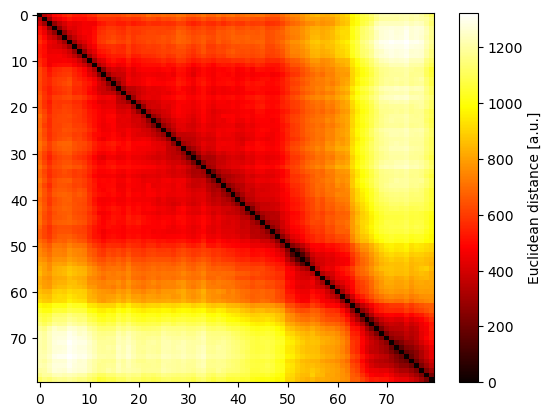

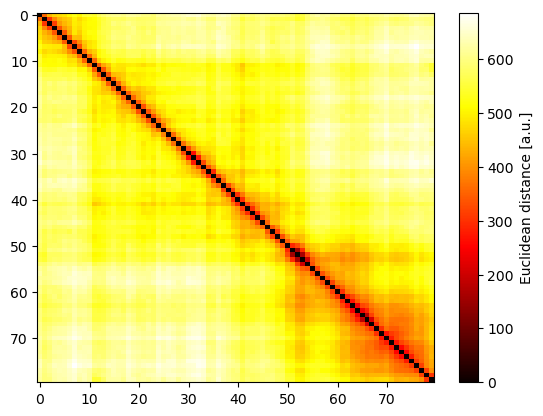

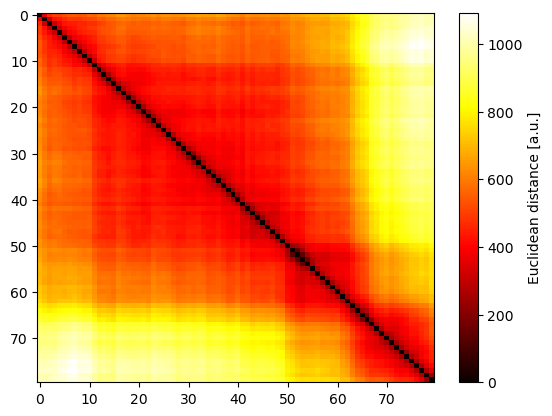

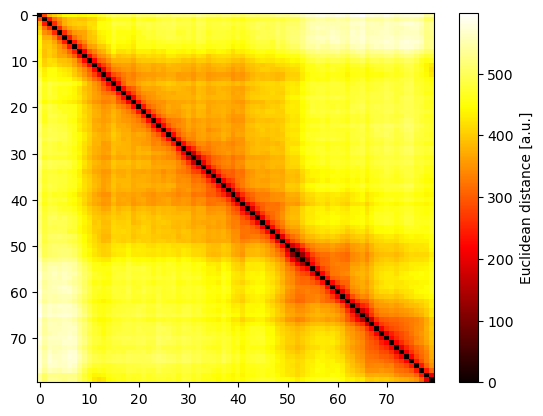

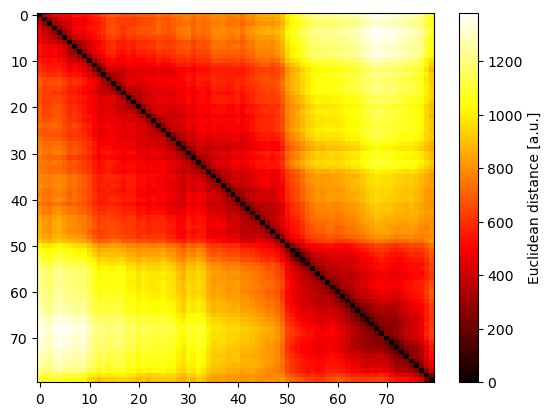

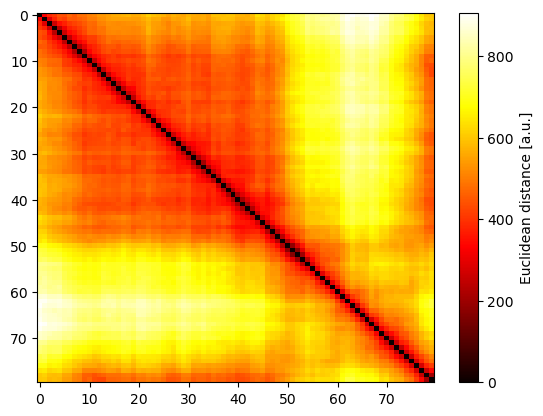

In [31]:
for x in bgmm.means_:
    visualize_dmap(x.reshape(80, -1))

In [42]:
covariance_type_list = ['full', 'tied', 'diag', 'spherical']
gmm_list = []    

In [43]:
for cov_type in covariance_type_list:
    gmm = GaussianMixture(n_components=10, covariance_type=cov_type, random_state=0, verbose=1)
    gmm.fit(all_maps_interp_flat)
    gmm_list.append(gmm)

Initialization 0
Initialization converged: True
Initialization 0
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
  Iteration 90
Initialization converged: True


In [45]:
err_list = []
for m in gmm_list:
    err = [np.linalg.norm(x - y) for x, y in zip(m.means_, bgmm.means_)]
    err_list.append(err)

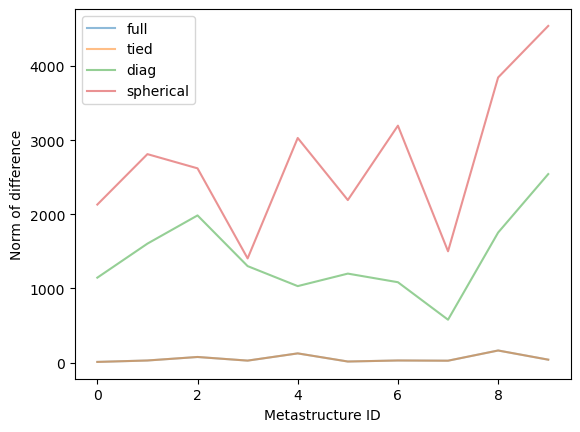

In [56]:
for i, err in enumerate(err_list):
    plt.plot(err, label=covariance_type_list[i], alpha=0.5)
plt.legend()
plt.xlabel('Metastructure ID')
plt.ylabel('Norm of difference')
plt.savefig(save_dir + '/gmm_error.png', dpi=300, bbox_inches='tight')

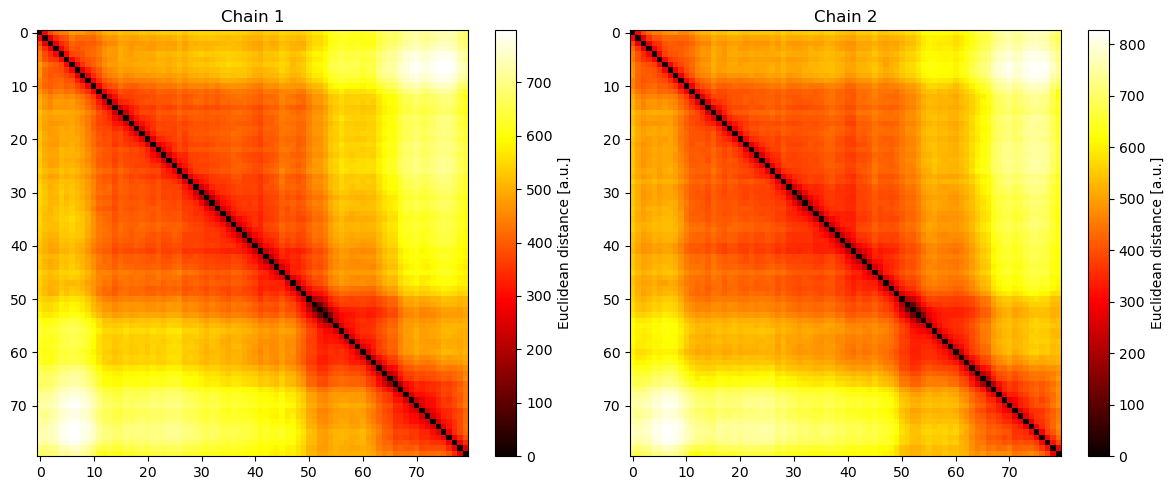

2131.7782465731466


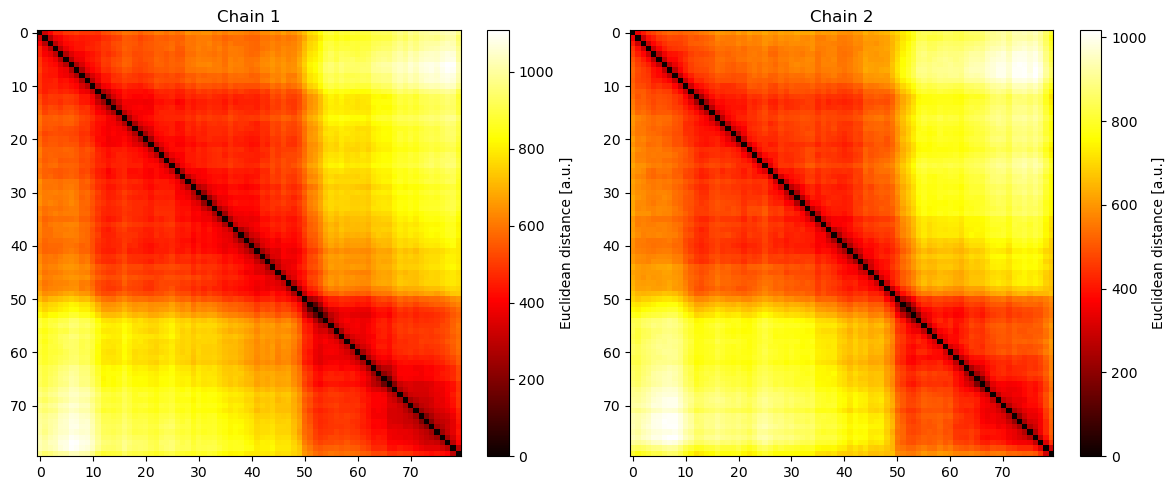

2812.35857068933


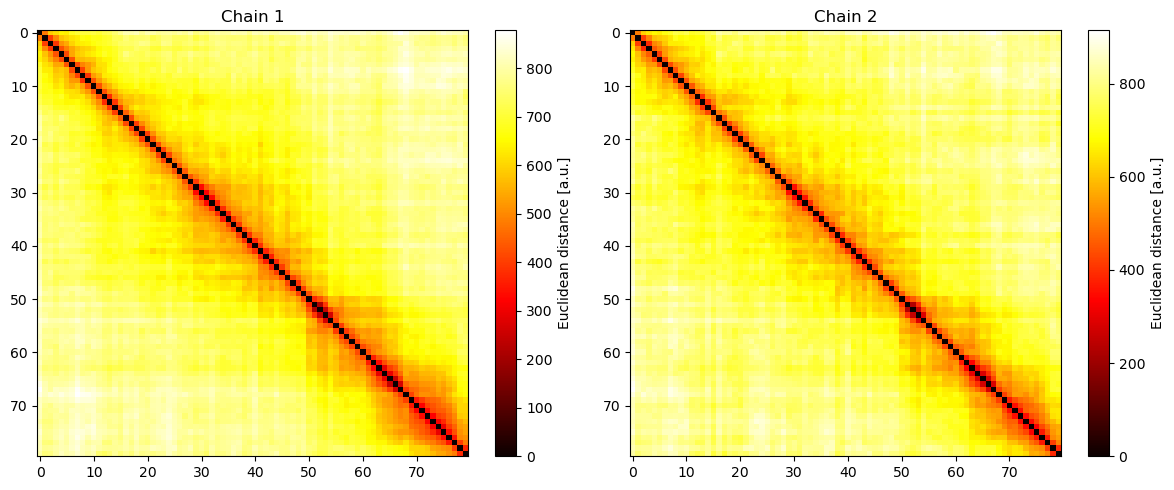

2620.615457090089


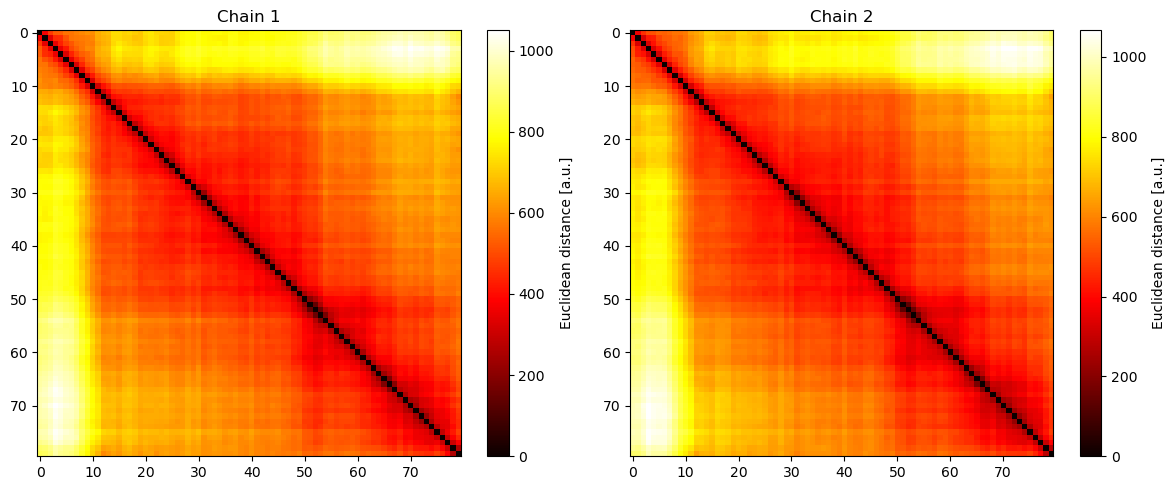

1405.0174591027976


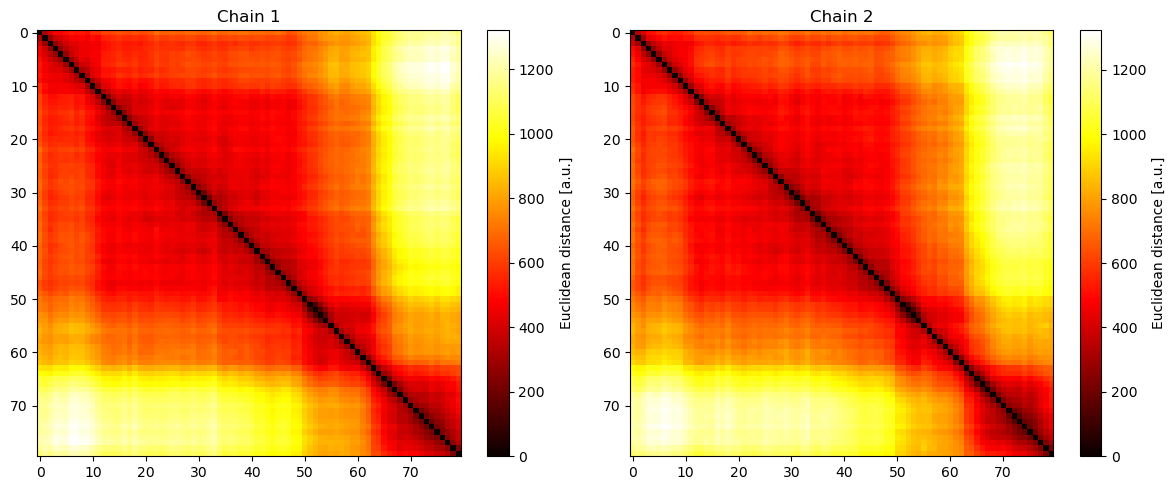

3030.410998406962


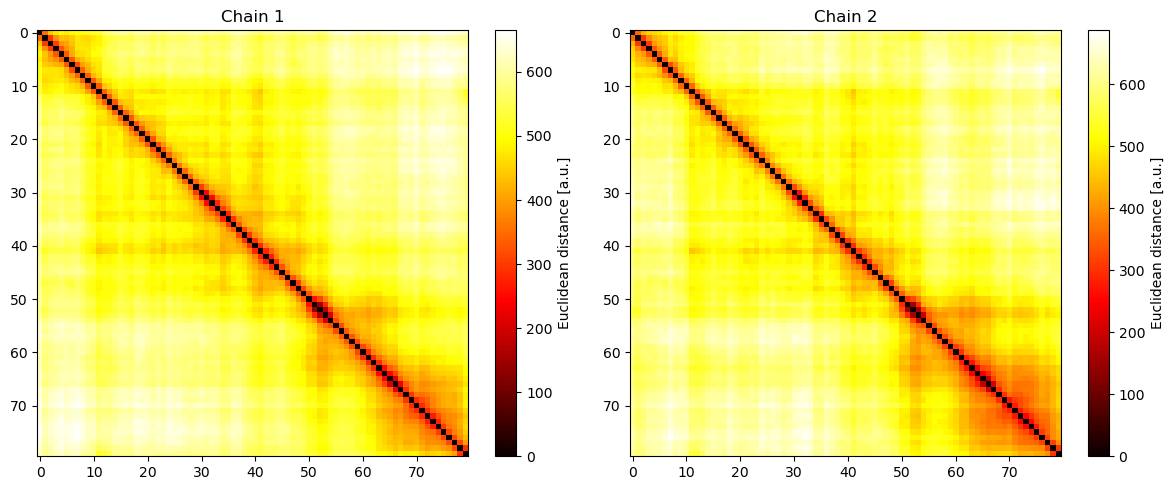

2192.633766882325


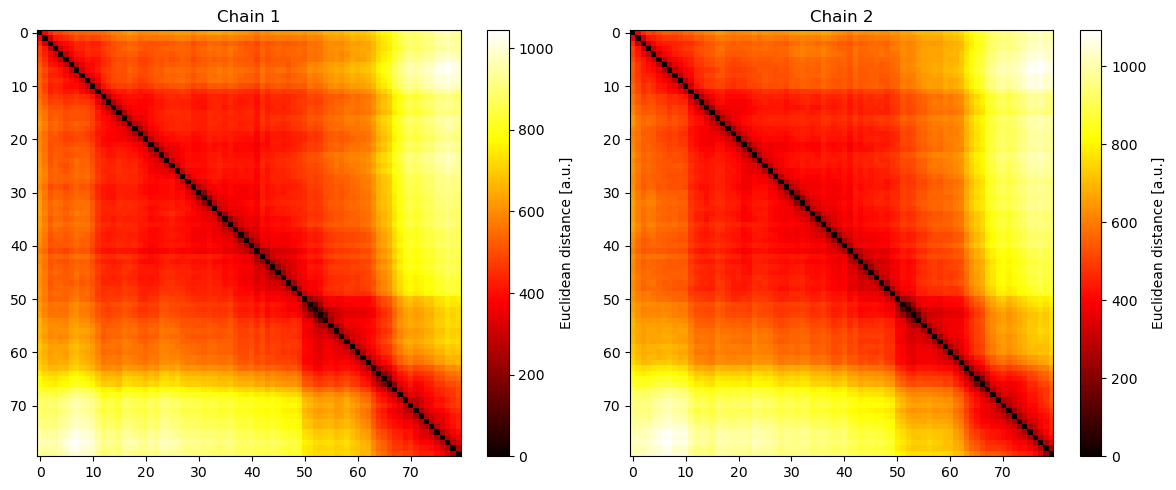

3196.445036554005


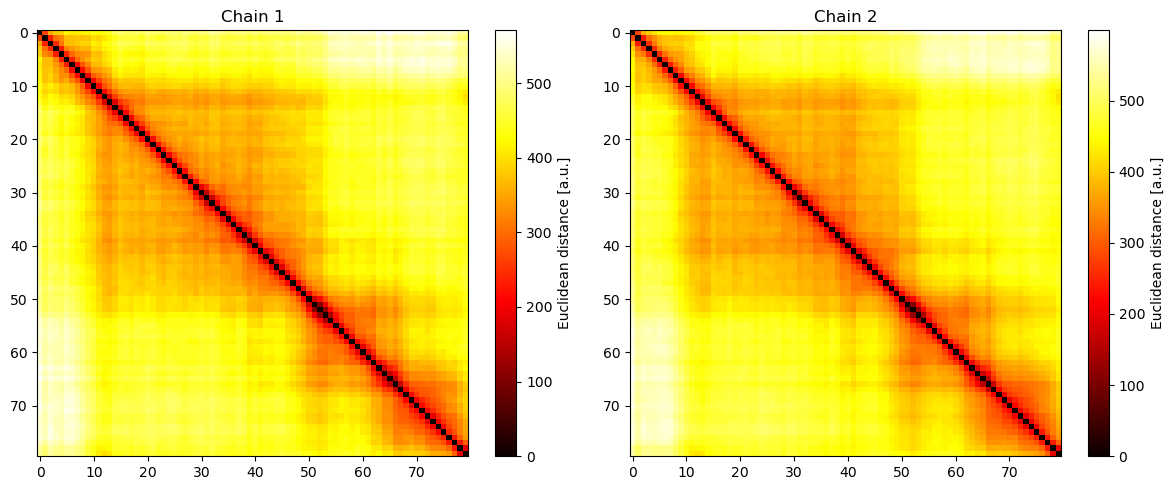

1501.3771799306176


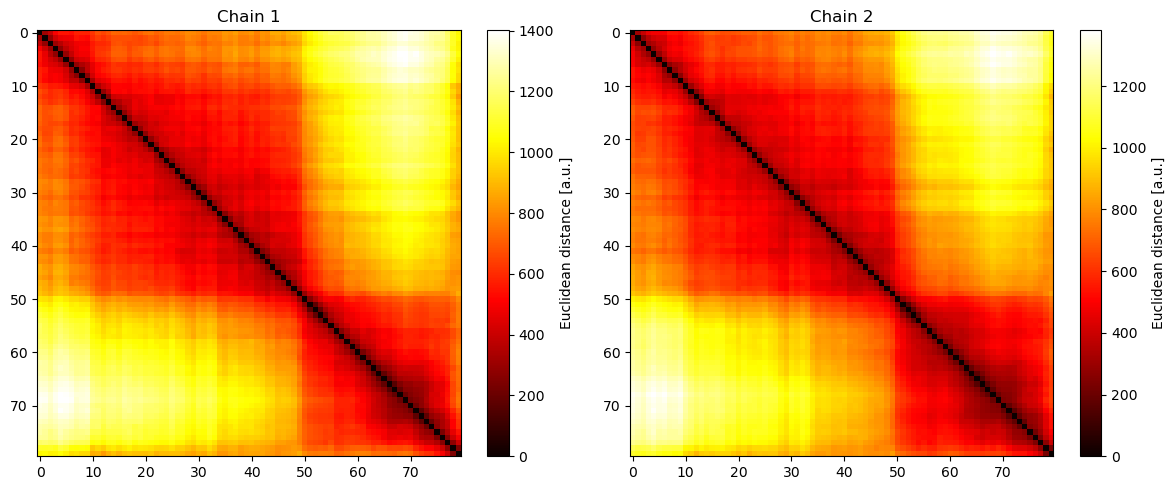

3846.9330298735927


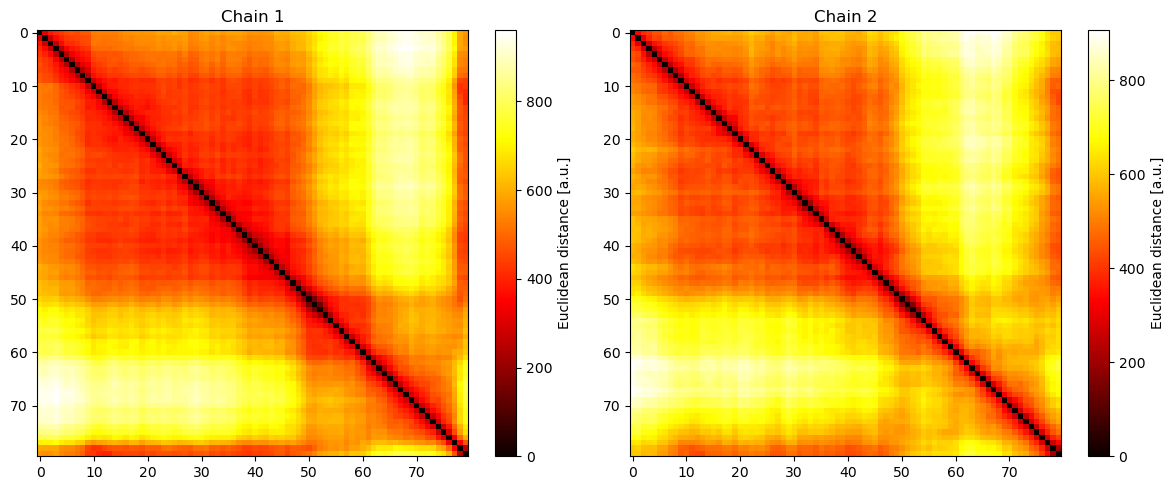

4542.411025141727


In [40]:
for x, y in zip(gmm.means_, bgmm.means_):
    compare_distance_maps(x, y, type1='flatten_distance_map', type2='flatten_distance_map')
    print(np.linalg.norm(x - y))
    

In [32]:
numpy.linalg.matrix_rank(bgmm.means_)

10

In [5]:
# Try Gaussian Mixture 
n_components = np.arange(0, 101, 5)
n_components[0] = 2
print(n_components)

[  2   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90  95 100]


In [58]:
aic_list = []
bic_list = [] 
for n in tqdm(n_components):
    gmm = GaussianMixture(n_components=n, covariance_type='tied', random_state=0, verbose=1)
    gmm.fit(all_maps_interp_flat)
    aic_list.append(gmm.aic(all_maps_interp_flat))
    bic_list.append(gmm.bic(all_maps_interp_flat))

  0%|          | 0/21 [00:00<?, ?it/s]

Initialization 0
Initialization converged: True
Initialization 0
Initialization converged: True


KeyboardInterrupt: 

In [57]:
plt.plot(n_components, aic_list, label='AIC')
plt.plot(n_components, bic_list, label='BIC')
plt.legend()
plt.xlabel('Number of Metastructure')

NameError: name 'aic_list' is not defined

In [36]:
# Try Gaussian Mixture 
n_components = np.arange(2, 21, 1)
print(n_components)

aic_list = []
bic_list = [] 
gmm_list = []
for n in tqdm(n_components):
    gmm = GaussianMixture(n_components=n, covariance_type='diag', random_state=0, verbose=1)
    gmm.fit(all_maps_interp_flat)
    gmm_list.append(gmm)
    aic_list.append(gmm.aic(all_maps_interp_flat))
    bic_list.append(gmm.bic(all_maps_interp_flat))

[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


  0%|          | 0/19 [00:00<?, ?it/s]

Initialization 0
  Iteration 10
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 0
  Iteration 10
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
Initialization 0
  Iteration 10
  

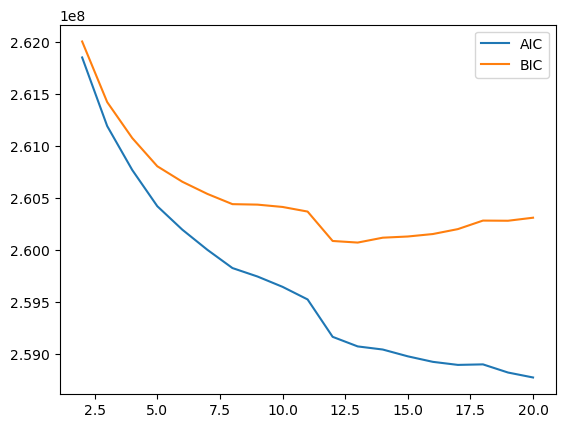

In [37]:
plt.plot(n_components, aic_list, label='AIC')
plt.plot(n_components, bic_list, label='BIC')
plt.legend()

In [38]:
# Look at the metastructures predicted by the best model 
best_gmm = gmm_list[np.argmin(bic_list)]

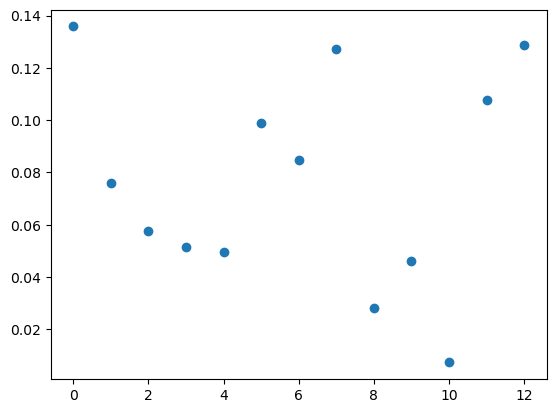

In [40]:
# Plot the weights 
plt.plot(best_gmm.weights_, 'o')

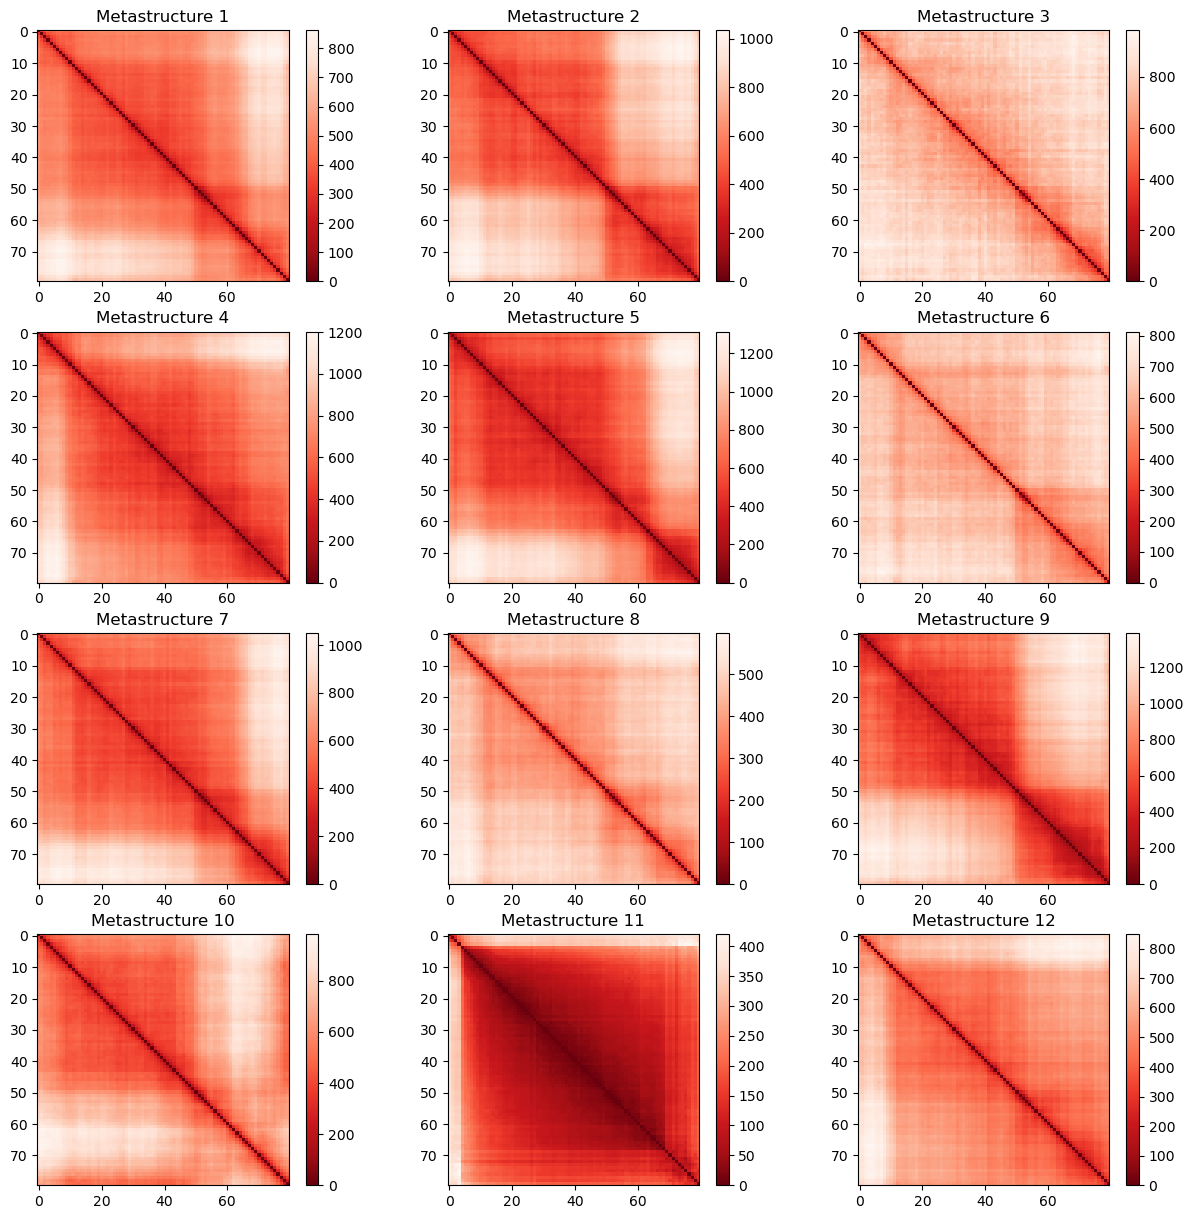

In [47]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
for i, ax in enumerate(axes.flat):
    im = ax.imshow(best_gmm.means_[i].reshape(-1, 80), cmap='Reds_r')
    ax.set_title(f'Metastructure {i+1}')
    fig.colorbar(im, ax=ax)


In [71]:
# Check if these clustering results are similar across different random states 
n_components = 12
random_state = np.arange(100)
gmm_random_state = []
for n in tqdm(random_state):
    gmm = GaussianMixture(n_components=n_components, covariance_type='diag', 
                          random_state=n, verbose=1, init_params='random'
                          n_init=10)
    gmm.fit(all_maps_interp_flat)
    gmm_random_state.append(gmm)

  0%|          | 0/100 [00:00<?, ?it/s]

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 0
  Iterat

/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: Tr

In [72]:
aic_list = [x.aic(all_maps_interp_flat) for x in gmm_random_state]
bic_list = [x.bic(all_maps_interp_flat) for x in gmm_random_state]

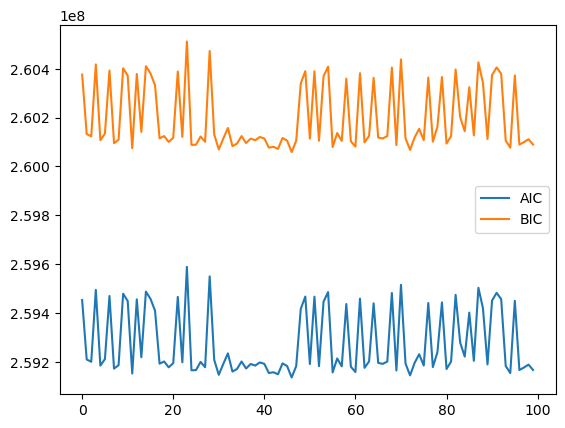

In [73]:
plt.plot(aic_list, label='AIC')
plt.plot(bic_list, label='BIC')
plt.legend()

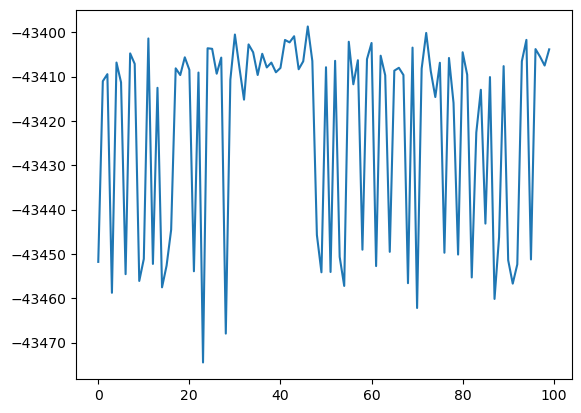

In [74]:
score_list = [x.score(all_maps_interp_flat) for x in gmm_random_state]
plt.plot(score_list)

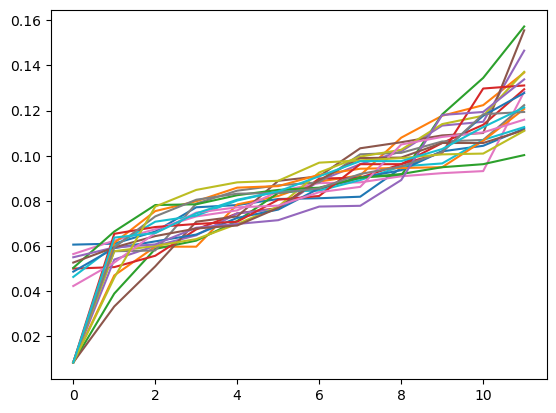

In [57]:
for x in gmm_random_state:
    plt.plot(np.sort(x.weights_))

In [79]:
best_gmm = gmm_random_state[np.argmax(score_list)]
sort_indices = np.argsort(best_gmm.weights_)[::-1]
means_sorted = best_gmm.means_[sort_indices]

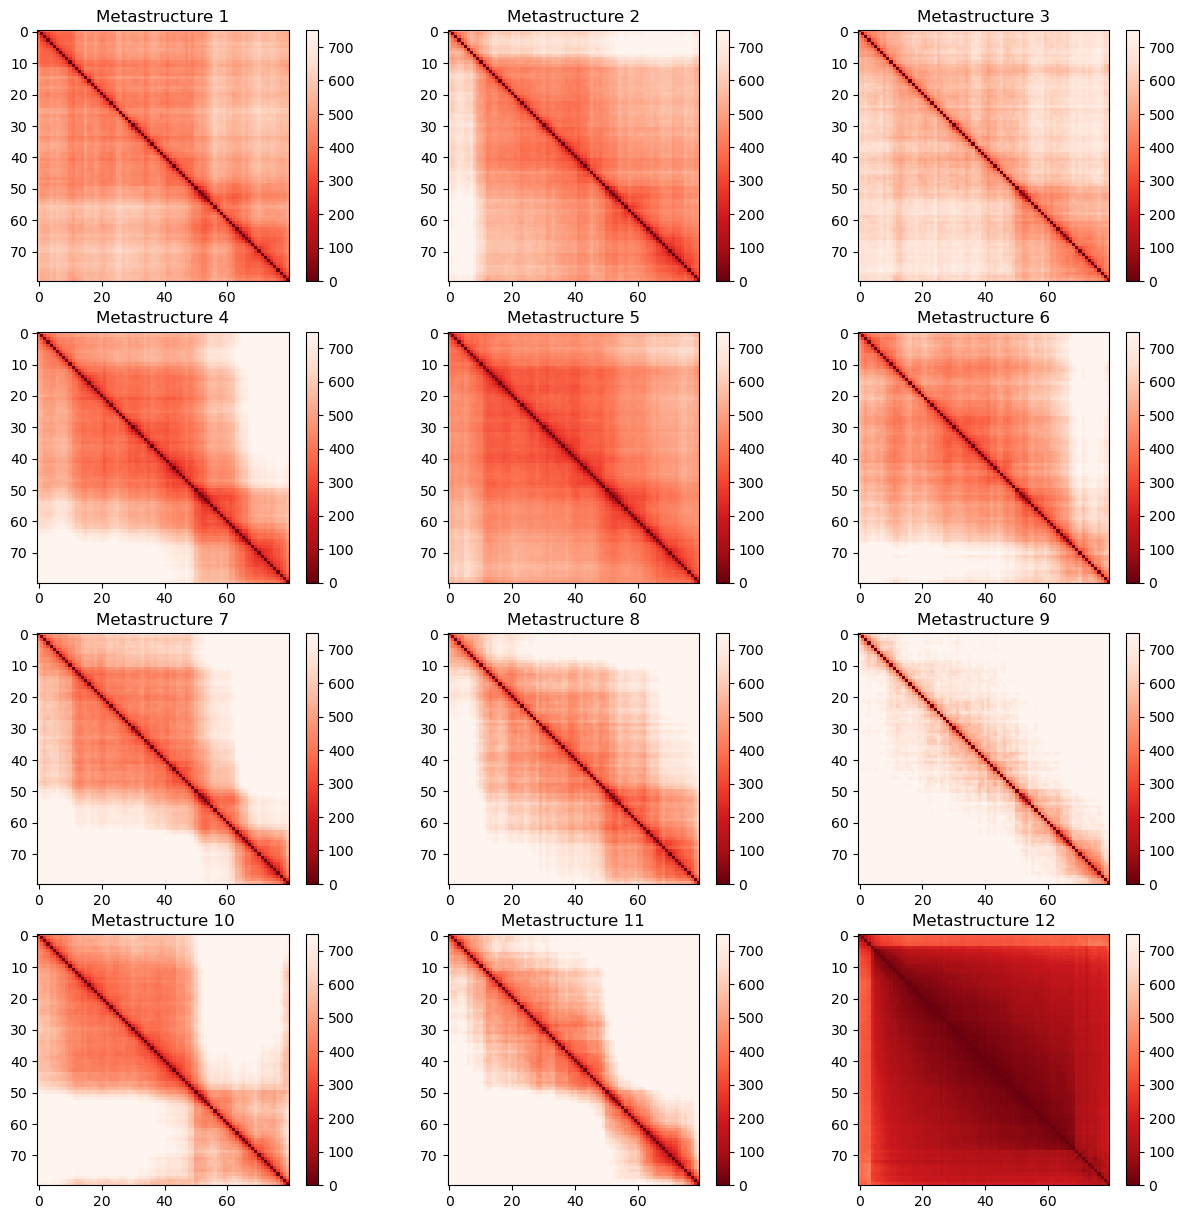

In [80]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
for i, ax in enumerate(axes.flat):
    im = ax.imshow(means_sorted[i].reshape(-1, 80), cmap='Reds_r', vmax=750)
    ax.set_title(f'Metastructure {i+1}')
    fig.colorbar(im, ax=ax)


In [83]:
cluster = best_gmm.predict(all_maps_interp_flat)
num_comp_sorted = [np.sum(cluster == i) for i in sort_indices]

Text(0, 0.5, 'Number of Cells')

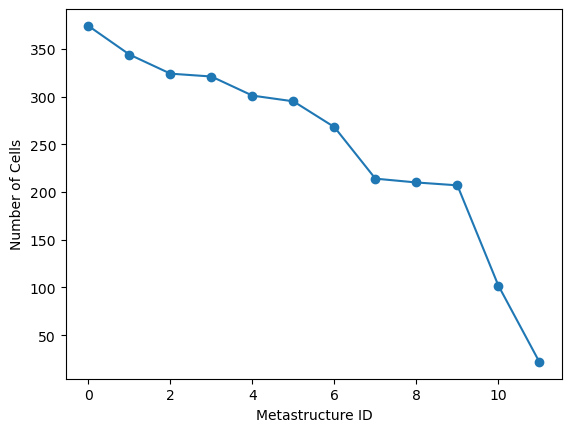

In [86]:
plt.plot(num_comp_sorted, '-o')
plt.xlabel('Metastructure ID')
plt.ylabel('Number of Cells')

In [87]:
# Save metastructures in a pickle file 
import pickle
save_path = '/mnt/home/tudomlumleart/ceph/05_Sox9Dataset/'
with open(save_path + 'common_metastructures.pkl', 'wb') as f:
    pickle.dump(means_sorted, f)

In [88]:
means_sorted.shape

(12, 6400)

In [100]:
np.sqrt(best_gmm.covariances_.mean(axis=1))

array([242.02087069, 164.77304711, 217.91063958, 363.87307879,
       291.68476834, 263.94173565, 264.92414449, 257.9325405 ,
       265.06164256, 231.62822879, 196.06058741, 339.8296662 ])

In [95]:
covariances_sorted = best_gmm.covariances_[sort_indices]

In [101]:
save_path = '/mnt/home/tudomlumleart/ceph/05_Sox9Dataset/'
with open(save_path + 'covariance_metastructures.pkl', 'wb') as f:
    pickle.dump(np.sqrt(covariances_sorted), f)

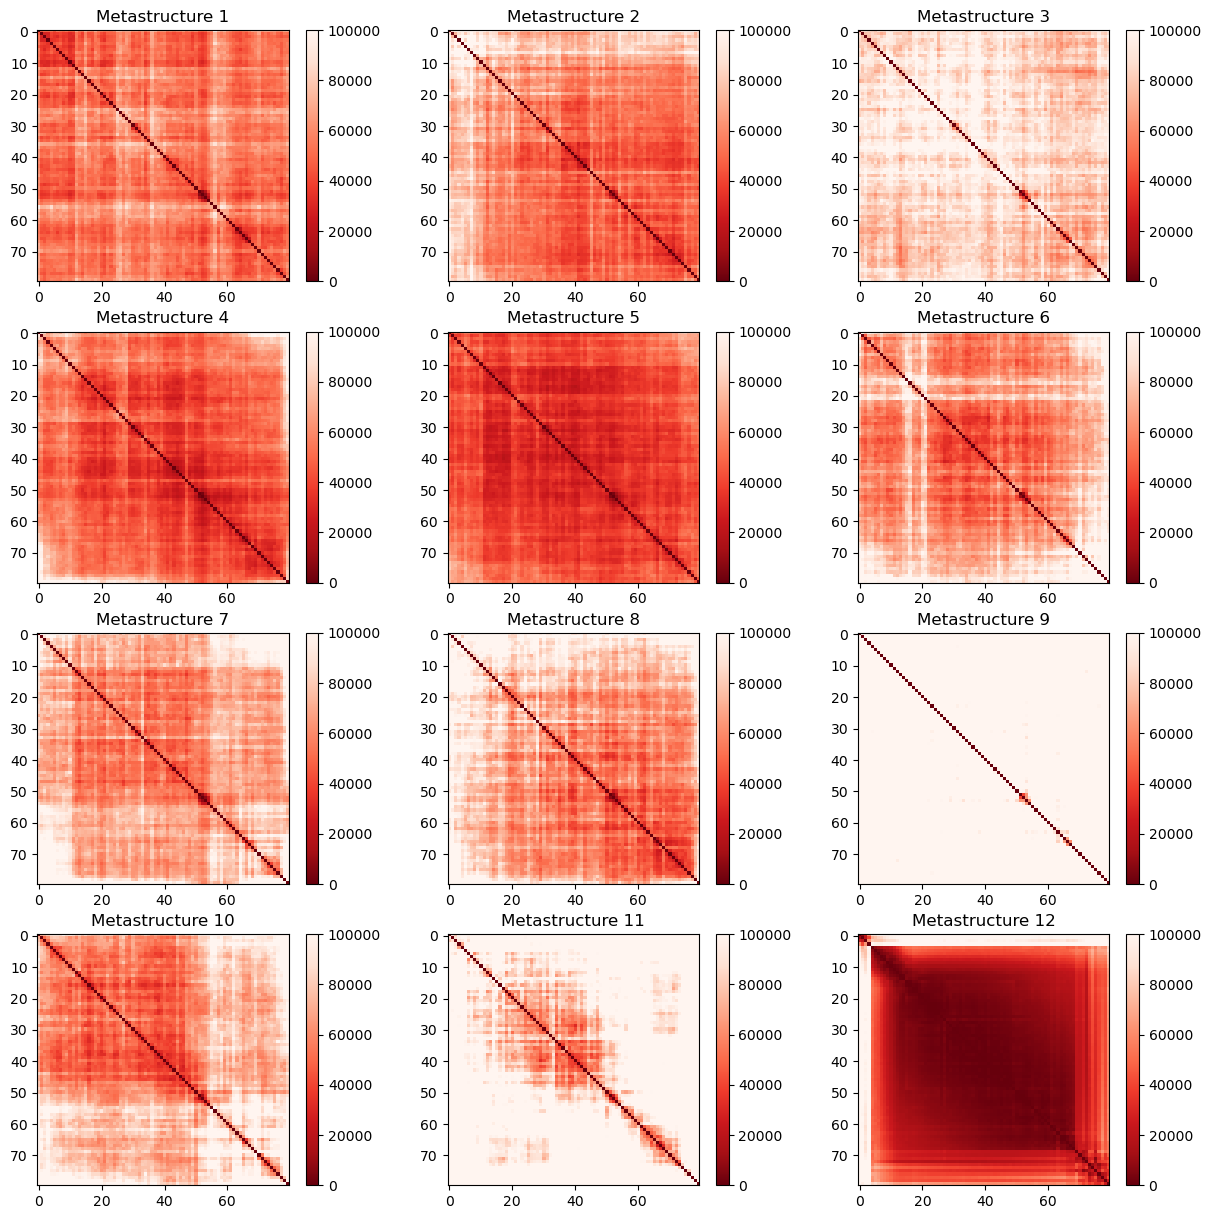

In [97]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
for i, ax in enumerate(axes.flat):
    im = ax.imshow(covariances_sorted[i].reshape(-1, 80), cmap='Reds_r', vmax=1e5)
    ax.set_title(f'Metastructure {i+1}')
    fig.colorbar(im, ax=ax)


In [25]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV


def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)

n_components = np.arange(0, 101, 5)
n_components[0] = 2


param_grid = {
    "n_components": n_components,
    "covariance_type": ["diag"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score, n_jobs=-1, verbose=2
)
grid_search.fit(all_maps_interp_flat)

Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV] END ...............covariance_type=diag, n_components=2; total time=   3.2s
[CV] END ...............covariance_type=diag, n_components=2; total time=   3.2s
[CV] END ...............covariance_type=diag, n_components=2; total time=   3.3s
[CV] END ...............covariance_type=diag, n_components=2; total time=   3.5s
[CV] END ...............covariance_type=diag, n_components=5; total time=   8.3s
[CV] END ...............covariance_type=diag, n_components=5; total time=   8.4s
[CV] END ...............covariance_type=diag, n_components=5; total time=   8.5s
[CV] END ...............covariance_type=diag, n_components=2; total time=   8.6s
[CV] END ...............covariance_type=diag, n_components=5; total time=   9.6s
[CV] END ..............covariance_type=diag, n_components=10; total time=   6.9s
[CV] END ..............covariance_type=diag, n_components=10; total time=   6.9s
[CV] END ..............covariance_type=diag, n_

GridSearchCV(estimator=GaussianMixture(), n_jobs=-1,
             param_grid={'covariance_type': ['diag'],
                         'n_components': array([  2,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100])},
             scoring=<function gmm_bic_score at 0x1554c61237f0>, verbose=2)

In [26]:
df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df.sort_values(by="BIC score").head()

,Number of components,Type of covariance,BIC score
1,5,diag,5.252235e+07
0,2,diag,5.255583e+07
2,10,diag,5.277757e+07
3,15,diag,5.312650e+07
4,20,diag,5.348993e+07


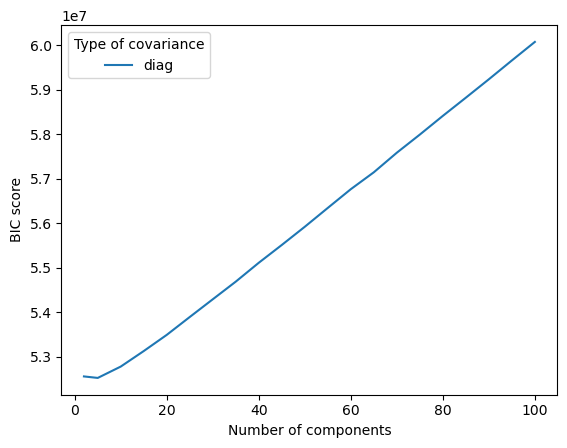

In [27]:
sns.lineplot(
    data=df,
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
)
plt.show()

In [29]:
# Number of components that minimizes BIC
df["Number of components"][df["BIC score"].idxmin()]

5

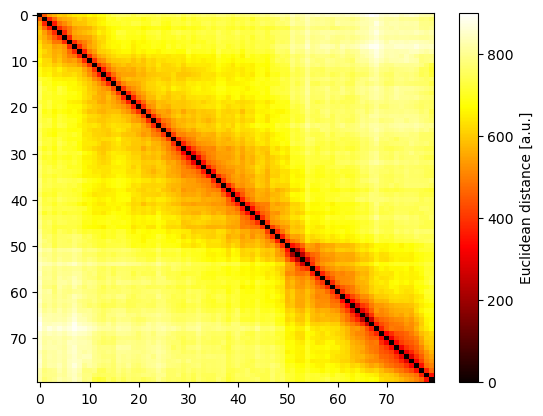

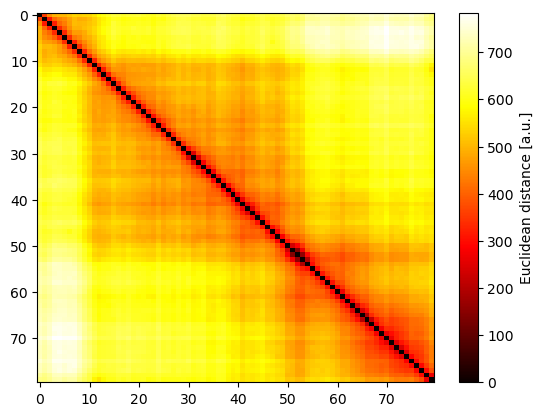

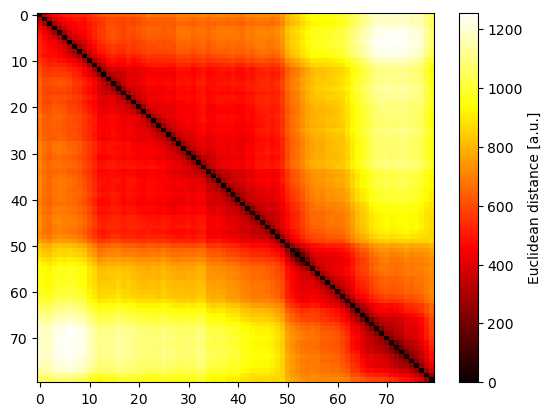

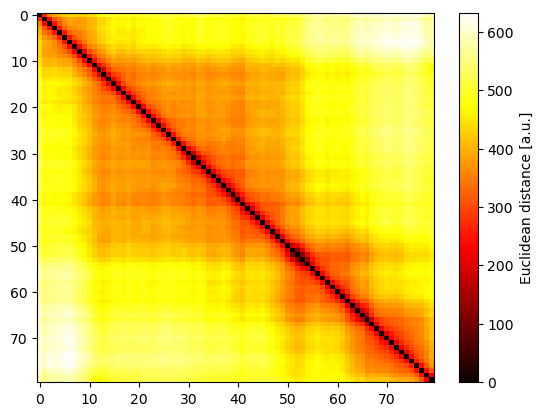

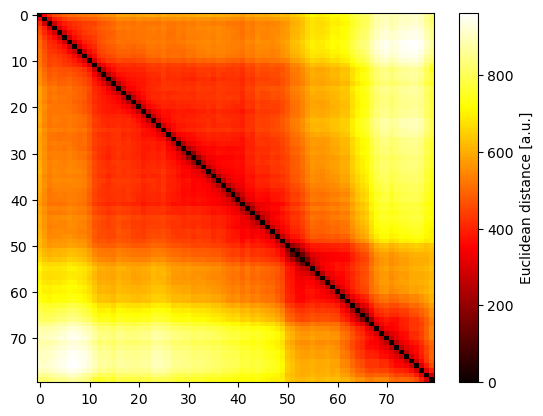

In [34]:
for i, x in enumerate(grid_search.best_estimator_.means_):
    visualize_dmap(x.reshape(80, -1), save_path=save_dir+'/metastructure_'+str(i)+'.png')

In [36]:
np.linalg.matrix_rank(grid_search.best_estimator_.means_)

5